## NW Alignment distributions for sentences

* "Documents" stored are lists of lemmas extracted from sentences in each SPLIT_NORM document
  * Catalan stop words removed
  * Named Entities replaced with tags "QUANT, DATE, MISC, PER, LOC, ORG"
* Currently, there are stored 6734 documents from 2209 files (there are 13,116 total files)
* Computing and storing intra-file Needleman-Wunsch scores (in alignments) finished in a reasonable time (~a minute)
    * For these 2209 files, it calculated 23,421 scores
* The distribution is left-skewed, indicating most documents are relatively dissimilar.

Here is an example of a list of lemma's from 2 documents with a score of 10:

* {que,en,el,termini,de,LN_m:6,ho,presentar,en,el,plenari_de_el_consell_municipal_de_l'_ajuntament_de_barcelona}
* {que,en,el,termini,de,LN_m:6,ho,presentar,en,el,consell_plenari_de_l'_ajuntament_de_barcelona}

**Important note: These scores are not scaled by length of the documents. Similar documents which are long will have a much higher score than shorter documents which are similar. The opposite is also true: longer documents which are extremely dissimilary will have much lower scores than shorter documents which are dissimilar.**

In [27]:
import psycopg2
conn = psycopg2.connect("dbname=testdb user=abarciauskas")
cur = conn.cursor()

cur.execute("SELECT Doc1Id,Doc2Id,Score FROM alignments")
scores = cur.fetchall()
cur.close()
conn.close()
scores[0]

(5240, 5241, -34)

In [28]:
score_list = [score[2] for score in scores]
print(len(score_list))
score_list = [item for item in score_list if item > -200]
print(len(score_list))

23421
23226


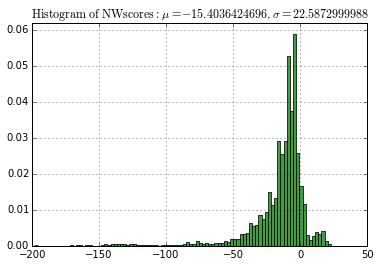

In [29]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(score_list, 100, normed=1, facecolor='green', alpha=0.75)
mu = np.mean(score_list)
sigma = np.std(score_list)
plt.title(r'$\mathrm{Histogram\ of\ NW scores:}\ \mu=' + str(mu) + ',\ \sigma=' + str(sigma) + '$')
# Note: there is a value lower, ths has cut some extremes
plt.axis([-200, 50, 0, 0.062])
plt.grid(True)

plt.show()

In [30]:
scores[0]

(5240, 5241, -34)

In [74]:
import numpy as np

conn = psycopg2.connect("dbname=testdb user=abarciauskas")

# get 10 pairs from each +/-1,2,3 standard deviations around the mean
sd_range = range(-3,3)
ranges = []
for i in sd_range:
    ranges.append((int(mu+i*sigma), int(mu+(i+1)*sigma)))

sd_sets = dict((el,[]) for el in ranges)

range_keys = sd_sets.keys()
ranges = [range(x[0], x[1]) for x in range_keys]

for score_tuple in scores:
    docid1, docid2, score = score_tuple
    bucket_idx = [i for i in range(len(ranges)) if score in ranges[i]]
    if len(bucket_idx) == 1:
        bucket_idx = bucket_idx[0]
        sd_sets[range_keys[bucket_idx]].append([docid1,docid2])

cur = conn.cursor()

select_total = 10
for key in range_keys:
    print '----------------'
    print "Key is: " + str(key)
    print ''
    doc_pairs = sd_sets[key][0:10]
    for pair in doc_pairs:
        doc1 = cur.execute("SELECT TaggedLemmas FROM processed_documents WHERE Id = " + str(pair[0]))
        res = cur.fetchone()
        print "Doc1 Lemmas: " + str(res)
        doc2 = cur.execute("SELECT TaggedLemmas FROM processed_documents WHERE Id = " + str(pair[1]))
        res = cur.fetchone() 
        print "Doc2 Lemmas: " + str(res)
        print ''

cur.close()
conn.close()

----------------
Key is: (-15, 7)

Doc1 Lemmas: (['es', 'anar', 'produir', 'robatori', 'interior', 'gimn\xc3\xa0s', 'reclamar', 'anar', 'sostreure', 'divers', 'objecte', 'NP', 'que', 'abonar', 'import', 'QUANT', 'total'],)
Doc2 Lemmas: (['laude', 'es', 'estimar', 'abonar', 'reclamar', 'QUANT', 'import', 'material', 'sostreure', 'considerar', 'que', 'gimn\xc3\xa0s', 'haver', 'tenir'],)

Doc1 Lemmas: (['NP', 'DATE', 'DATE', 'NP', 'DATE', 'es', 'reunir', 'NP', 'NP', 'NP', 'actuar', 'NP', 'DATE', 'NP', 'NP', 'NP'],)
Doc2 Lemmas: (['NP', 'NP', 'NP', 'NP', 'NP', 'NP', 'NP', 'NP', 'NP', 'NP', 'NP', 'NP', 'NP'],)

Doc1 Lemmas: (['NP', 'DATE', 'DATE', 'NP', 'DATE', 'es', 'reunir', 'NP', 'NP', 'NP', 'actuar', 'NP', 'DATE', 'NP', 'NP', 'NP'],)
Doc2 Lemmas: (['es', 'donar', 'PER', 'DATE', 'esborrany', 'haver', 'ser', 'trametre', 'membre', 'NP', 'es', 'aprovar'],)

Doc1 Lemmas: (['NP', 'DATE', 'DATE', 'NP', 'DATE', 'es', 'reunir', 'NP', 'NP', 'NP', 'actuar', 'NP', 'DATE', 'NP', 'NP', 'NP'],)
Doc2 L